# Graphs

**Prerequisites**

- Python Setup

**Outcomes**

- Understand key components of networks/graphs
- Use the networkx package for working with graphs in Python
- Implement the breadth-first search algorithm

**References**

- [Easley and Kleinberg](https://www.cs.cornell.edu/home/kleinber/networks-book/) chapter 2

## Why Study Graphs?
- Economic, cultural, political, and social interactions are influenced by *structure* of relationships
  - Transmission of viruses
  - International trade, supply chains, marketplaces
  - Spread of information, diffusion of innovation
  - Political persuasion, localized voting patterns
  - Human behaviors influenced by network of friends (sports, clothes, music)
- Behaviors can be effected by social networks
  - "Influencers"
  - Circles of followers can create echo chambers

## Edges and Nodes

- A **graph** specifies relationships between a collection of items
- Each item is called a **node**
- A relationship between nodes is represented by an **edge**
- Visually, graphs might look like this:

![./graph_structure.png](./graph_structure.png)

- Here the nodes are `A`, `B`, `C`, `D`
- The edges connect nodes `A-B`, `B-C`, `B-D`, `C-D`

## Adjacency Matrix

- How might we represent the graph above numerically?
- One very common approach is to use a matrix of 0's and 1's called an *adjancency matrix*
- Suppose we have a graph of $N$ nodes
  - Without loss of generality, we'll represent them as integers `1:N`
- Let $A \in \{0,1\}^{N \times N}$ be our adjacency matrix
- Element $A_{ij}$ will be zero unless there is an edge between nodes $i$ and $j$ (diagonal is left as $0$)
- In our above we had
  - Nodes `A`, `B`, `C`, `D` (or 1, 2, 3, 4 respectively)
  - Edges connecting nodes `1-2`, `2-3`, `2-4`, `3-4`
- The adjacency matrix for this example is
$$A = \begin{bmatrix}
0 & 1 & 0 & 0 \\
1 & 0 & 1 & 1 \\
0 & 1 & 0 & 1 \\
0 & 1 & 1 & 0
\end{bmatrix}$$

## Graphs in Python

- In Python there are a few ways we could represent our example graph above
- We could start with the adjacency matrix concept as follows

In [1]:
import numpy as np

A = np.array([[0, 1, 0, 0], [1, 0, 1, 1], [0, 1, 0, 1], [0, 1, 1, 0]])
A

array([[0, 1, 0, 0],
       [1, 0, 1, 1],
       [0, 1, 0, 1],
       [0, 1, 1, 0]])

### Working with Adjacency Matrices

- An adjacency matrix gives us a lot of information about the structure of the graph
- We could compute all of the following
  - Total number of nodes: number of rows or columns of $A$
  - Total number of edges: $\sum_{ij} A_{ij}$
  - Node with most edges: $\text{argmax}_{i} \sum_{j} A_{i,j}$
  - Average number of edges per node: $N \cdot \sum_{i,j} A_{i,j}$


### Exercise: Adjacency Matrix

- In the cell below we have defined an adjacency matrix called `A_ex1`
- Using `A_ex1` answer the following questions:
  - How many nodes are in the graph?
  - How many edges?
  - Node with most edges (hint, use the `dims` argument to `sum` and then the `argmax` function)
  - Average number of edges per node
  - Number of connections for node 7: $\sum_j A_{j7}$

In [2]:
def random_adjacency_matrix(n):
    out = np.random.randint(0, 2, size=(n, n))
    # remove diagonal elements -- no self edges
    np.fill_diagonal(out, 0)

    # make symmetric
    out = (out + out.T) // 2
    return out

A_ex1 = random_adjacency_matrix(30)


## Networkx

- Python has excellent support for working with graphs
- There are a variety of packages, but the most popular is the [networkx](https://networkx.github.io) package
-  We can use our adjacency matrix to create a Graph using networkx


In [3]:
import networkx as nx

In [4]:
g1 = nx.convert_matrix.from_numpy_array(A)

In [5]:
g1.edges

EdgeView([(0, 1), (1, 2), (1, 3), (2, 3)])

In [6]:
g1.nodes

NodeView((0, 1, 2, 3))

- We can use the `nx.draw` function to visualize our graph
- Note that the actual placement of the nodes is randomly generated and then tweaked to clearly show all nodes and edges
- The important thing is *not* the placement of nodes, but rather their *relative structure*

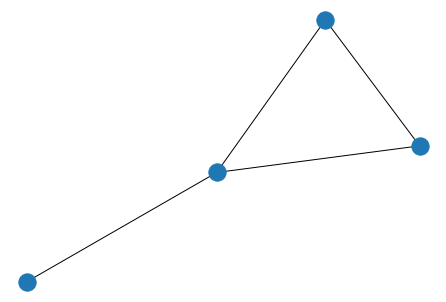

In [7]:
nx.draw(g1)

## Size considerations

- Using a numpy array of floats (or ints) to store an adjacency matrix turns out to be a rather costly way to store a graph
- In the original example graph we had 4 nodes and 4 edges
- To store this we needed to have a 4x4 matrix of 64 bit integers
  - This is only 128 bytes in our exapmle,
  - But consider a graph of websites and links between them -- that graph would have millions of nodes and edges...
- There are a few approaches to reducing this storage cost:
  - Only store the upper triangle of the matrix
  - Use Boolean ( 1 bit!) instead of int as the array's dtype
  - Use a [sparse matrix](https://docs.scipy.org/doc/scipy/reference/sparse.html)
  - Store as a `List[EDGES]` (where edges is some container that stores all edges coming out of a single node)

In [8]:
A2 = {0: [1], 1: [0, 2, 3], 2: [1, 3], 3: [1, 2]}

- It turns out that this is similar to what networkx does internally.

In [9]:
g1.adj

AdjacencyView({0: {1: {'weight': 1}}, 1: {0: {'weight': 1}, 2: {'weight': 1}, 3: {'weight': 1}}, 2: {1: {'weight': 1}, 3: {'weight': 1}}, 3: {1: {'weight': 1}, 2: {'weight': 1}}})

## Graph Theory Concepts

- Let's explore some concepts often used in analysis of graphs

### Paths

- When studying graphs it is often natural to ask about how things travel or flow across the graph
- For example, how information spreads amongst a group of friends, how data travels the internet, how diseases are transmitted from one person to another, and how people navigate a metro subway system
- In each of these cases, the flow of things goes from node to node across edges
- A flow from one any node to another node is called a **path**

## Arpanet Example

- Consider the following Graph of the first iteration of the internet

![./arpanet_map.png](./arpanet_map.png)

- There are many possible paths through this network
- Consider a path from UCSB to MIT: `UCSB-UCLA-RAND-BBN-MIT`
- Another possible path from UCSB to MIT is `UCSB-SRI-UTAH-MIT`

## networkx Arpanet

- Let's define the Arpanet using networkx as it will be helpful throughout this lecture

In [10]:
nodes = {
    "UCSB": ["SRI", "UCLA"],
    "SRI": ["UCSB", "UCLA", "STAN", "UTAH"],
    "UCLA": ["SRI", "UCSB", "STAN", "RAND"],
    "STAN": ["SRI", "UCLA"],
    "UTAH": ["SRI", "SDC", "MIT"],
    "SDC": ["UTAH", "RAND"],
    "RAND": ["UCLA", "SDC", "BBN"],
    "MIT": ["UTAH", "BBN", "LINC"],
    "BBN": ["MIT", "RAND", "HARV"],
    "LINC": ["MIT", "CASE"],
    "CASE": ["LINC", "CARN"],
    "CARN": ["CASE", "HARV"],
    "HARV": ["CARN", "BBN"]
}

In [11]:
arpa = nx.Graph(nodes)

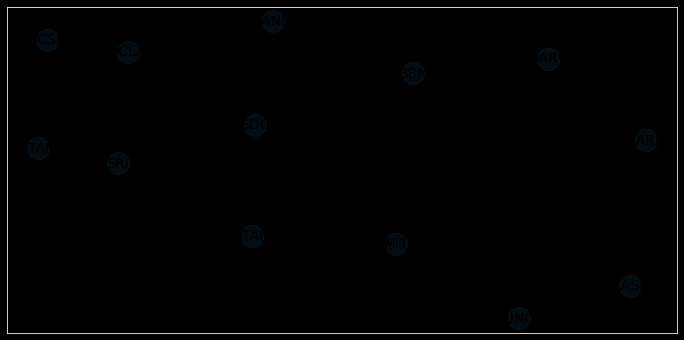

In [12]:
import matplotlib.pyplot as plt

def plot_arpa(arpa):
    pos = nx.spring_layout(arpa, seed=22)
    fig, ax = plt.subplots(figsize=(12, 6))
    nx.draw_networkx_nodes(arpa, pos, node_size=500, alpha=0.1)
    nx.draw_networkx_edges(arpa, pos, alpha=0.7)
    nx.draw_networkx_labels(arpa, pos, font_size=14);

plot_arpa(arpa)

## Cycles

- An important concept when analyzing graphs is the concept of a cycle
- A cycle is a path that starts and ends at the same node
- For the ARPA net, an example cycle is `LINC-CASE-CARN-HARV-BBN-MIT-LINC`
- Question... what is the shortest possible cycle in a graph (including all endpoints)?
- networkx can tell us if a graph is connected

In [13]:
nx.is_connected(arpa)

True

- It is natural to believe that many real-world networks are connected
  - Transportation: you can get to any station
  - Internet: you can visit any website
- But it is entirely possible to have a non-connected graph
  - Social networks (nodes: people, edges: friendships) of college students who different countries
  - Suppliers for a textile company vs a microchip manufacturer

## Distance

- We can extend concept of paths between nodes, to include a notion of distance
- The **length** of a path is the number of steps it takes from beginning to end
  - `MIT-BBN-RAND-UCLA` has length 3 (starting from `MIT` take three steps before ending at `UCLA`)
- The **distance** between two nodes, is the length of the *shortest* path between those nodes
- networkx can compute distances using the `shortest_path_length` function
- Below we compute the distance between `UCLA` and all nodes

In [14]:
nx.shortest_path_length(arpa, "UCLA")

{'UCLA': 0,
 'RAND': 1,
 'STAN': 1,
 'UCSB': 1,
 'SRI': 1,
 'BBN': 2,
 'UTAH': 2,
 'SDC': 2,
 'MIT': 3,
 'HARV': 3,
 'CARN': 4,
 'LINC': 4,
 'CASE': 5}

## Breadth-First Search

- If asked, how would you go about computing the distance between the `HARV` node and all other nodes?
- One iterative approach might be:
  - Start with `HARV`: note it is distance zero to `HARV`
  - Move on to all nodes directly connected to `HARV`: these are distance 1
  - Then move to all nodes connected to nodes that are distance 1 from `HARV` (excluding any you may have already found): declare these to be at distance 2 from `HARV`
  - Continue traversing edges until you have visited all nodes
- This algorihtm is called **breadth-first search**

### Example: Breadth-First Search from MIT

- The image below shows how breadth-first search would proceed for the MIT node

![./mit_breadth_first.png](./mit_breadth_first.png)

## Exercise (difficult!): BFS

- Now it is time for you to try this out!
- Our goal is to use breadth-first search to compute the distance betwen a given node and all other nodes
- The return value you end up with should be an `List[List[X]]` (X is the label for a node), where element `i` of the outer list contains all node labels at distance `i` from the starting node
- Fill in the logic for the `breadth_first_distances` function below

In [15]:
def breadth_first_distances(g: nx.Graph, start):
    out = []
    ### BEGIN SOLUTION
    visited = {start}
    starting_nodes = [start]
    while len(visited) != len(g.nodes):
        new_nodes = []
        for node in starting_nodes:
            for neighbor in g.neighbors(node):
                if neighbor not in visited:
                    new_nodes.append(neighbor)
                    visited.add(neighbor)
        out.append(new_nodes)
        starting_nodes = new_nodes

    ### END SOLUTION
    return out

In [16]:
breadth_first_distances(arpa, "MIT")

[['UTAH', 'BBN', 'LINC'],
 ['SRI', 'SDC', 'RAND', 'HARV', 'CASE'],
 ['UCSB', 'UCLA', 'STAN', 'CARN']]

## BFS with networkx

- The networkx library contains routines implementing breadth-first search
- The main function is called `nx.breadth_first_search.bfs_tree`

In [18]:
bfs_bbn = nx.breadth_first_search.bfs_tree(arpa, "BBN")
bfs_bbn

In [19]:
len(bfs_bbn.nodes), len(bfs_bbn.edges)

(13, 12)

- Notice that the printout says we have a graph with 13 nodes, 12 edges and it is a **directed** graph
- Thus far, all graphs we have considered have been undirected
  - We have only been concerned about if a connection (edge) exists between nodes
- A directed graph extends the notion of connecting nodes with a direction
  - We can now say that *things* flow across edges from one node to another -- always in the same direction
- Why would the breadth-first search routine return a directed graph instead of the undirected type we started with?
- Let's visualize it and see if we can understand why

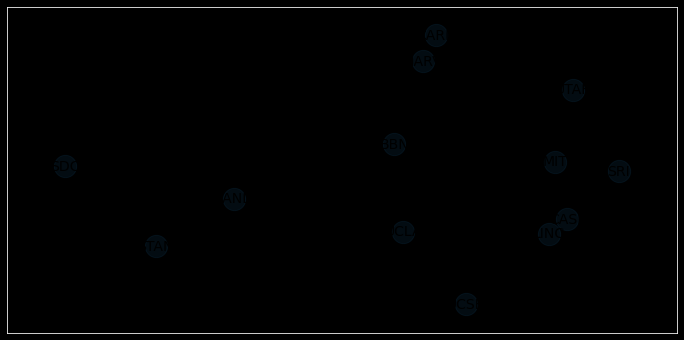

In [20]:
plot_arpa(bfs_bbn)

- Notice that arrows only flow *out* of `BBN`
- They also always flow *away* from `BBN`
- The use of directed edges allows networkx to represent the shortest path from BBN to any other node
  - For example `STAN`: `BBN -> RAND -> UCLA -> STAN`

In [21]:
type(bfs_bbn)

networkx.classes.digraph.DiGraph

### Exercise: BFS with NetworkX

- The `bfs_bbn.adj` gives a dictionary describing the adjacency pattern in this directed graph
- Each key of this dict is a node label
- The values of the dict describe which nodes are pointed at by the key
-  Below we have set up a new function `bfs_tree_distances` that takes a `DiGraph` as an argument
- Your task is to implement the the method so that it has the same return value as the `breadth_first_distances` function above

In [22]:
def bfs_tree_distances(g: nx.DiGraph, start):
    out = []

    ### BEGIN SOLUTION
    to_visit = [start]
    while len(to_visit) > 0:
        new_nodes = []
        for node in to_visit:
            new_nodes.extend(list(g.adj[node]))
        
        if len(new_nodes) > 0:
            out.append(new_nodes)
        to_visit = new_nodes

    ### END SOLUTION
    return out

In [23]:
bfs_tree_distances(bfs_bbn, "BBN")

[['RAND', 'MIT', 'HARV'],
 ['UCLA', 'SDC', 'UTAH', 'LINC', 'CARN'],
 ['UCSB', 'SRI', 'STAN', 'CASE']]

## Components

- A *component* of a graph is a self-contained subset of the nodes
- More precisely, a set of nodes is a component if
  1. Every node in the subset has a path to every other node in the subset
  2. The subset is not part of a larger set with property (1)
- Example:

![./graph_components.png](./graph_components.png)

### Example

- How many components are in this graph?

![./hs_dating_graph.png](./hs_dating_graph.png)